# Introduction

## Welcome to this notebook for building a GAN from scratch !       
### In this Notebook, you'll find a step-by-step tutorial on how to obtain and visualize the data, as well as building and visualizing the results of a GAN ! :) 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision.utils import make_grid
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# PART 1: Getting and visualizing the data

## For this notebook, we're going to use the ImageFolder dataset class from PyTorch to create our dataset easily. We will create two datasets: one for our Monet paintings, the other for our photos.

In [16]:
# Get the paths for our data
monet_jpg = Path('../input/gan-getting-started/monet_jpg')
monet_tfrec = Path('../input/gan-getting-started/monet_tfrec')
photo_jpg = Path('../input/gan-getting-started/photo_jpg')
photo_tfrec = Path('../input/gan-getting-started/photo_tfrec')
ROOT = '../input/gan-getting-started'

In [17]:
print('We have',len(list(monet_jpg.glob('**/*.jpg'))), 'paintings made by Monet')
print('We have',len(list(photo_jpg.glob('**/*.jpg'))), 'pictures')

We have 300 paintings made by Monet
We have 7038 pictures


## So, we know that we have way more pictures than Monet paintings. Now, let's see what they look like. But first, let's define some variables that will serve as our parameters

In [18]:
IMG_SIZE = (128,128)
workers = 2

nc = 3 # Number of channels, 3 since we have RGB images
nz = 100
ngf = 64
ndf = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRANSFORMS = [
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
]


# Now, let's create a special class for loading up our data, since Pytorch doesn't allow for .tfrec file extension in the dataloader

In [19]:
class LoadImage():
    """
    Helper class that will take in a dataset and apply transformation then return the dataset.
    """
    
    def __init__(self, path, size=IMG_SIZE, transformations=None):
        self.path = path
        self.transformations = TRANSFORMS
        
        if self.transformations:
            self.transform = transforms.Compose(self.transformations)
        
        self.img_idx = dict()
        for num_, img_ in enumerate(os.listdir(self.path)):
            self.img_idx[num_] = img_
            
    def __len__(self):
        return len(self.img_idx)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.img_idx[idx])
        img = Image.open(img_path)
        img = self.transform(img)
        
        return img

In [20]:
monet_data = LoadImage('../input/gan-getting-started/monet_jpg', size=IMG_SIZE, transformations=TRANSFORMS)
photo_data = LoadImage('../input/gan-getting-started/photo_jpg', size=IMG_SIZE, transformations=TRANSFORMS)

In [21]:
# Check we have the correct number of pictures
print(monet_data.__len__())
print(photo_data.__len__())

300
7038


In [22]:
train_monet_size = int(0.8*monet_data.__len__())
test_monet_size = monet_data.__len__() - train_monet_size
train_photo_size = int(0.8*photo_data.__len__())
test_photo_size = photo_data.__len__() - train_photo_size

print(train_monet_size,test_monet_size,train_photo_size,test_photo_size)

240 60 5630 1408


In [23]:
train_monet, test_monet = torch.utils.data.random_split(monet_data, [train_monet_size, test_monet_size])
train_photo, test_photo = torch.utils.data.random_split(photo_data, [train_photo_size, test_photo_size])

In [24]:
train_monet_data = torch.utils.data.DataLoader(train_monet, batch_size=1,
                                              shuffle=True, num_workers=workers)
test_monet_data = torch.utils.data.DataLoader(test_monet, batch_size=1,
                                              shuffle=True, num_workers=workers)
train_photo_data = torch.utils.data.DataLoader(train_photo, batch_size=1,
                                              shuffle=True, num_workers=workers)
test_photo_data = torch.utils.data.DataLoader(test_photo, batch_size=1,
                                              shuffle=True, num_workers=workers)


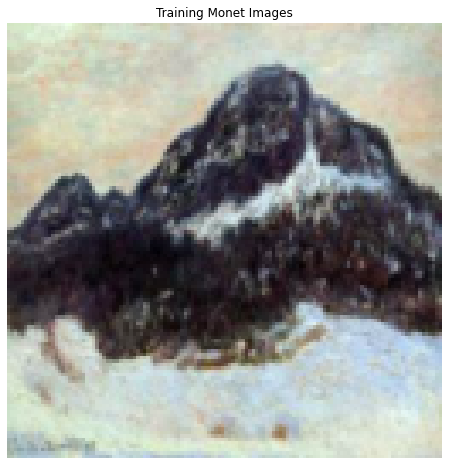

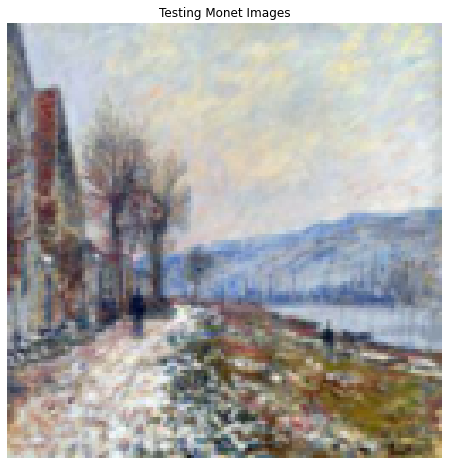

In [25]:
real_batch = next(iter(train_monet_data))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Monet Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to('cuda:0')[:64], padding=2, normalize=True).cpu(),(1,2,0)))

real_batch = next(iter(test_monet_data))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Monet Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to('cuda:0')[:64], padding=2, normalize=True).cpu(),(1,2,0)))

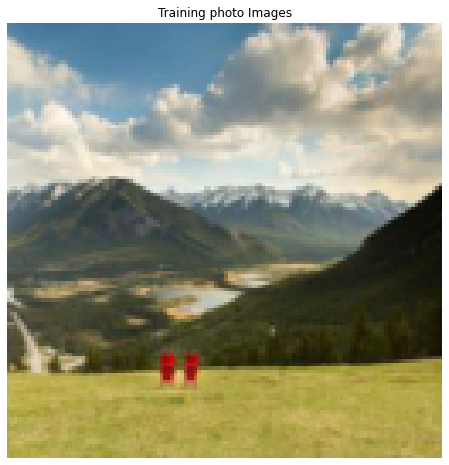

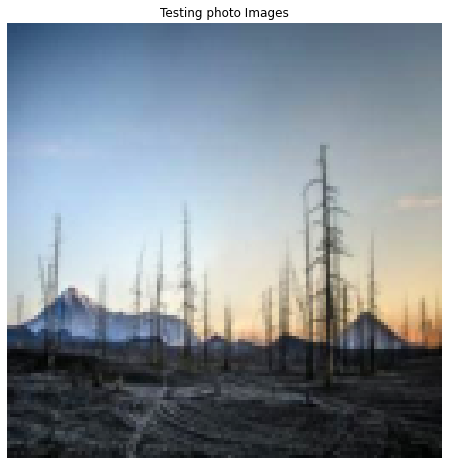

In [26]:
real_batch = next(iter(train_photo_data))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training photo Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to('cuda:0')[:64], padding=2, normalize=True).cpu(),(1,2,0)))

real_batch = next(iter(test_photo_data))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing photo Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to('cuda:0')[:64], padding=2, normalize=True).cpu(),(1,2,0)))